In [3]:
%matplotlib inline

import numpy as np
import os
import json
import pandas as pd
from matplotlib import pyplot as plt

In [41]:
nproc = range(1, 11)

In [32]:
def speedup(t_serial, t):
    return t_serial/t

In [97]:
def read_profiling_files(profile_dir_path="."):
    profiling_data = pd.DataFrame()

    json_filenames = [file for file in os.listdir(profile_dir_path) if file.endswith("_profiling.json")]

    for json_filename in json_filenames:
        with open(os.path.join(profile_dir_path, json_filename)) as json_file:
            profiling_data = profiling_data.append(json.load(json_file), ignore_index=True)

    profiling_data = profiling_data.sort_values(by=["n_processes"])

    return profiling_data

profiling_data = read_profiling_files()
print(profiling_data)

     t_init     t_total                                            outfile  \
0  3.391605  195.295240  /work/martinls/216868/ShallowWaterGPU/mpi_out_...   
1  3.187037  179.881221  /work/martinls/216869/ShallowWaterGPU/mpi_out_...   
3  2.478722  148.845790  /work/martinls/216870/ShallowWaterGPU/mpi_out_...   
4  3.220587   89.258778  /work/martinls/216871/ShallowWaterGPU/mpi_out_...   
2  3.995742   81.342442  /work/martinls/216872/ShallowWaterGPU/mpi_out_...   
5  4.426121   76.431902  /work/martinls/216873/ShallowWaterGPU/mpi_out_...   

   t_sim_init  t_nc_write      t_step  t_step_mpi_halo_exchange  t_step_mpi  \
0   24.366352    4.218516  162.692996                 31.031250  131.203125   
1   13.079974    2.645470  160.504349                 30.175781  129.562500   
3    9.327793    1.417720  135.224608                 23.125000  111.355469   
4    7.693858    1.044866   76.910678                 42.898438   33.703125   
2    6.430108    0.975855   69.577638                 42.6

## Weak scaling

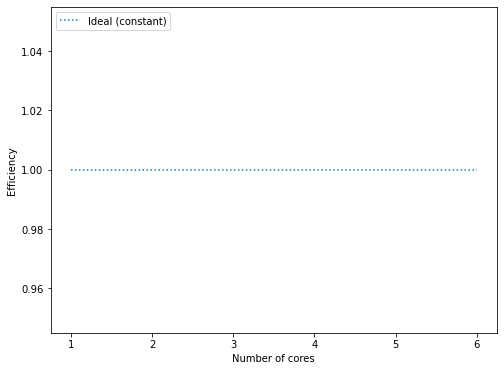

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

#ax.plot(nproc, speedup, label="Actual")

ax.plot(nproc, np.ones(len(nproc)), label="Ideal (constant)", linestyle="dotted")

ax.set_xlabel("Number of cores/GPUs")
ax.set_ylabel("Efficiency")
ax.legend(loc="upper left")
fig.show()

## Strong scaling

In [35]:
def amdahls_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [1.0 / (serial_share + parallel_share / float(n)) for n in nproc]

In [36]:
def gustafsons_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [serial_share + parallel_share * float(n) for n in nproc]

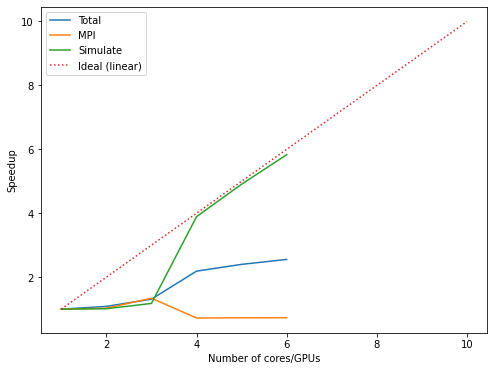

In [101]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_total"][0], profiling_data["t_total"]), label="Total")

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_step_mpi_halo_exchange"][0], profiling_data["t_step_mpi_halo_exchange"]), label="MPI")

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_step_mpi"][0], profiling_data["t_step_mpi"]), label="Simulate")

#ax.plot(nproc, amdahls_speedup(0.9, nproc), label="Amdahls 90%", linestyle="dashed")
#ax.plot(nproc, amdahls_speedup(0.5, nproc), label="Amdahls 50%", linestyle="dashed")
#ax.plot(nproc, amdahls_speedup(0.1, nproc), label="Amdahls 10%", linestyle="dashed")

#ax.plot(nproc, gustafsons_speedup(0.9, nproc), label="Gustafsons 90%")
#ax.plot(nproc, gustafsons_speedup(0.5, nproc), label="Gustafsons 50%")
#ax.plot(nproc, gustafsons_speedup(0.1, nproc), label="Gustafsons 10%")

ax.plot(nproc, nproc, label="Ideal (linear)", linestyle="dotted")

ax.set_xlabel("Number of cores/GPUs")
ax.set_ylabel("Speedup")
ax.legend(loc="upper left")
fig.show()

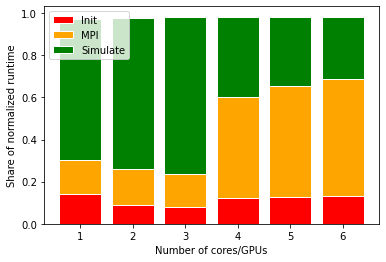

In [108]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])/profiling_data["t_total"]
share_mpi = profiling_data["t_step_mpi_halo_exchange"]/profiling_data["t_total"]
share_simulate = profiling_data["t_step_mpi"]/profiling_data["t_total"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Share of normalized runtime")
plt.legend(loc="upper left")

plt.show()